<a href="https://colab.research.google.com/github/reemchaaban/game_system/blob/main/data-processing/player_count_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install workalendar
!pip install huggingface_hub transformers
!pip install mlflow
!pip install pyngrok --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 1.5 MB/s eta 0:00:00
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732000 sha256=60d6d8ac4a38a97ce4bcf2d40ce28d790e2aaa8ee42c02e2ee13792978062508
  Stored in directory: /root/.cache/pip/wheels/8f/bd/f9/5c4c39b529e0322b08979e1c465e203218bc2cca75d20f7df5
Successfully built pymeeus
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import Callback
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import holidays
from workalendar.usa import UnitedStates  # can change
from datetime import datetime, timedelta
import pickle

from google.colab import drive, files, userdata
import os

import mlflow
import mlflow.tensorflow
from pyngrok import ngrok

from huggingface_hub import login, HfApi, HfFolder, Repository, create_repo, upload_folder

In [3]:
HF_TOKEN = userdata.get("HF_TOKEN")
NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
GITHUB_PAT = userdata.get('GITHUB_PAT')

In [4]:
login(token=HF_TOKEN)

In [6]:
# load dataset
drive.mount('/content/drive')
drive_base_path = '/content/drive/My Drive/503Nproj/datasets'
file_path = os.path.join(drive_base_path, 'player_count_history.csv')
df = pd.read_csv(file_path, parse_dates=['date'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# feature engineering
us_holidays = holidays.US()
cal = UnitedStates()
df['is_holiday_holidays_lib'] = df['date'].apply(lambda x: int(x in us_holidays))
df['is_holiday_workalendar'] = df['date'].apply(lambda x: int(cal.is_holiday(x)))
df['day_of_week'] = df['date'].dt.dayofweek  # i.e., monday=0, tuesday=1, ..., sunday=6

In [8]:
# target column & features
target_col = 'total players'
feature_cols = [col for col in df.columns if col not in ['date', target_col]]

In [9]:
# scaling
scaler_players = MinMaxScaler()
df[[target_col]] = scaler_players.fit_transform(df[[target_col]])  # train only on total players
with open('scaler_players.pkl', 'wb') as f:
    pickle.dump(scaler_players, f)
print(f"Scaler was trained on {scaler_players.n_features_in_} features")


scaler_features = MinMaxScaler()
df[feature_cols] = scaler_features.fit_transform(df[feature_cols])


Scaler was trained on 1 features


In [10]:
print(df.isnull().sum()) # get number of missing values
df.fillna(df.mean(), inplace=True)

date                       0
570                        0
730                        0
578080                     0
1172470                    0
                          ..
1086940                    0
total players              0
is_holiday_holidays_lib    0
is_holiday_workalendar     0
day_of_week                0
Length: 102, dtype: int64


In [11]:
print(df.dtypes)


date                       datetime64[ns]
570                               float64
730                               float64
578080                            float64
1172470                           float64
                                ...      
1086940                           float64
total players                     float64
is_holiday_holidays_lib           float64
is_holiday_workalendar            float64
day_of_week                       float64
Length: 102, dtype: object


In [12]:
# sequence preparation
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :-1])  # features
        y.append(data[i + seq_length, -1])  # target variable i.e., total players
    return np.array(X), np.array(y)

seq_length = 30  # use last 30 days to predict
data = df[feature_cols].values
X, y = create_sequences(data, seq_length)

# train-validation-test split (0.7-0.15-0.15)
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
test_size = len(X) - train_size - val_size
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]


In [13]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}") #verify that X train & test shapes make sense
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (489, 30, 99), y_train shape: (489,)
X_test shape: (106, 30, 99), y_test shape: (106,)


In [15]:
mlflow.tensorflow.autolog(disable=True)

class MLflowLoggingCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"\nEpoch {epoch} logs: {logs}\n")
        for key, value in logs.items():
            mlflow.log_metric(key, value, step=epoch)

In [25]:
# LSTM model training
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(seq_length, X.shape[2])),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

with mlflow.start_run(run_name="player-count-predictor"):
  model.fit(X_train, y_train,
            epochs=30,
            batch_size=16,
            validation_data=(X_test, y_test),
            callbacks=[MLflowLoggingCallback()])

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1538 - mae: 0.3309 - mse: 0.1538
Epoch 0 logs: {'loss': 0.1316794455051422, 'mae': 0.3089166581630707, 'mse': 0.1316794455051422, 'val_loss': 0.11134225130081177, 'val_mae': 0.28843727707862854, 'val_mse': 0.11134225130081177}

31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.1524 - mae: 0.3295 - mse: 0.1524 - val_loss: 0.1113 - val_mae: 0.2884 - val_mse: 0.1113
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1161 - mae: 0.2921 - mse: 0.1161
Epoch 1 logs: {'loss': 0.12164680659770966, 'mae': 0.2978580594062805, 'mse': 0.12164680659770966, 'val_loss': 0.11006203293800354, 'val_mae': 0.2869580388069153, 'val_mse': 0.11006203293800354}

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.1163 - mae: 0.2923 - mse: 0.1163 - val_loss: 0.1101 - val_mae: 0.2870 - val_mse: 0.1101
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1245 - mae: 0.3036 - mse: 0.1245
Epoch 2 logs: {'loss': 0.12042395025491714, 'mae': 0.297124385

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step


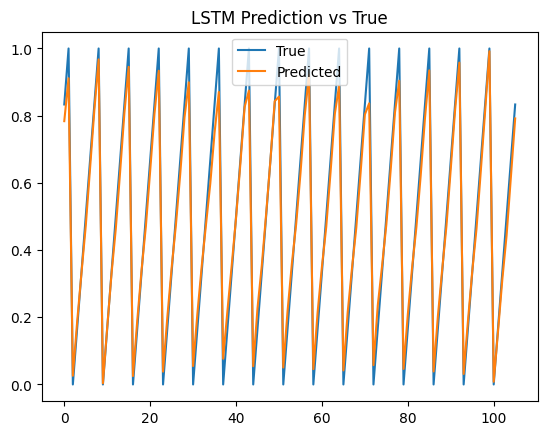

In [26]:
# model evaluation
y_pred = model.predict(X_test)

plt.plot(np.arange(len(y_test)), y_test, label="True")
plt.plot(np.arange(len(y_pred)), y_pred, label="Predicted")
plt.legend()
plt.title("LSTM Prediction vs True")

plt.savefig("prediction_plot.png")

In [27]:
print(model.input_shape)  # expecting: (None, sequence_length, feature_size)


(None, 30, 99)


In [28]:
def predict_future(date):
    date = pd.to_datetime(date)
    day_of_week = date.weekday()
    is_holiday_holidays = int(date in us_holidays)
    is_holiday_workalendar = int(cal.is_holiday(date))

    last_seq = df[feature_cols].values[-seq_length:]  # ensure the shape is correct

    # ensure extra_features has same number of columns as features
    extra_features = np.zeros(len(feature_cols))  # replace null values w/ zeros
    extra_features[-3:] = [day_of_week / 6.0, is_holiday_holidays, is_holiday_workalendar]  # normalization

    # stack last_seq w/ extra_features
    last_seq = np.vstack([last_seq[1:], extra_features])  # (seq_length, num_features)

    # reshape sequence to (1, seq_length, num_features)
    last_seq = np.expand_dims(last_seq, axis=0)  # shape (1, seq_length, num_features)

    # ensure input shape matches model's expected input (99 features)
    last_seq = last_seq[:, :, :99]  # trim/select first 99 features

    print(f"last_seq shape before prediction: {last_seq.shape}")  # ensure last sequence shape is what we expect
    print(f"Last input sequence:\n{last_seq}")

    # prediction
    prediction = model.predict(last_seq)
    print(f"Raw model output: {prediction[0][0]}")  # debugging

    # check inverse transformation
    predicted_players_scaled = np.array([[prediction[0][0]]])  # shape should be (1, 1)

    predicted_players = scaler_players.inverse_transform(predicted_players_scaled)[0][0]

    print(f"Predicted total players (scaled): {prediction[0][0]}")
    print(f"Predicted total players after inverse transform: {predicted_players}")

    # debugging
    print("Scaler Min:", scaler_players.data_min_)
    print("Scaler Max:", scaler_players.data_max_)

    # manual computation of inverse transformation
    min_val = scaler_players.data_min_[0]  # min value used in training
    max_val = scaler_players.data_max_[0]  # max value used in training
    predicted_manual = min_val + (max_val - min_val) * prediction[0][0]

    print("Manually-calculated inverse transform:", predicted_manual)

    # extra debugging
    print(f"Day of week (normalized): {day_of_week / 6.0}")
    print(f"Holiday feature 1: {is_holiday_holidays}")
    print(f"Holiday feature 2: {is_holiday_workalendar}")

    return predicted_players

# test w/ future date
future_date = "2025-04-18"
predict_future(future_date)

last_seq shape before prediction: (1, 30, 99)
Last input sequence:
[[[0.32600305 0.8271795  0.76030521 ... 0.10815171 0.         0.        ]
  [0.36596354 0.91537016 0.8116333  ... 0.12318548 0.         0.        ]
  [0.13071803 0.71624328 0.75790826 ... 0.10026211 1.         1.        ]
  ...
  [0.06112511 0.90901566 0.91060804 ... 0.07094232 0.         0.        ]
  [0.2081065  1.         0.95082665 ... 0.09067778 0.         0.        ]
  [0.         0.         0.         ... 0.         0.66666667 0.        ]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Raw model output: 0.5731843709945679
Predicted total players (scaled): 0.5731843709945679
Predicted total players after inverse transform: 6226531.5
Scaler Min: [4719905.]
Scaler Max: [7348425.]
Manually-calculated inverse transform: 6226531.582846642
Day of week (normalized): 0.6666666666666666
Holiday feature 1: 0
Holiday feature 2: 0


np.float32(6226531.5)

In [29]:
model.export("player_count_model")

Saved artifact at 'player_count_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 99), dtype=tf.float32, name='keras_tensor_14')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135048205484112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135048205486032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135048205486608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135048205485648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135048205487184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135048205487760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135048205485072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135048205488144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135048205486992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135048205488912: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [30]:
! pkill -f "mlflow ui"

get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background

In [31]:
# terminate any open tunnels
ngrok.kill()

ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# open HTTP tunnel on port 5000 = http://localhost:5000
public_url = ngrok.connect(5000, proto="http")

print(f" * Ngrok tunnel: {public_url}")

 * Ngrok tunnel: NgrokTunnel: "https://0110-35-237-135-32.ngrok-free.app" -> "http://localhost:5000"


In [32]:
upload_folder (
    repo_id="reemchaaban/player-count-prediction",
    folder_path="player_count_model",
    path_in_repo="player_count_model",
    commit_message="Initial commit from Google Colab"
)


fingerprint.pb:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/129k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

variables.data-00000-of-00001:   0%|          | 0.00/1.33M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/reemchaaban/player-count-prediction/commit/7d1d7c285ce6ac110ac738caa342ccd970863154', commit_message='Initial commit from Google Colab', commit_description='', oid='7d1d7c285ce6ac110ac738caa342ccd970863154', pr_url=None, repo_url=RepoUrl('https://huggingface.co/reemchaaban/player-count-prediction', endpoint='https://huggingface.co', repo_type='model', repo_id='reemchaaban/player-count-prediction'), pr_revision=None, pr_num=None)

In [33]:
GITHUB_USERNAME = "reemchaaban"
GITHUB_EMAIL = "reem.chaabann@gmail.com"
REPO_NAME = "game_system"
BRANCH = "main"
TARGET_SUBDIR = "IEP1"

token = userdata.get('GITHUB_PAT')

!git config --global user.email "{GITHUB_EMAIL}"
!git config --global user.name "{GITHUB_USERNAME}"

!rm -rf {REPO_NAME}
!git clone https://{token}@github.com/{GITHUB_USERNAME}/{REPO_NAME}.git

!rm -rf {REPO_NAME}/{TARGET_SUBDIR}/model
!mkdir -p {REPO_NAME}/{TARGET_SUBDIR}/model
!ls
!cp player_count_model/fingerprint.pb {REPO_NAME}/{TARGET_SUBDIR}/model/
!cp player_count_model/saved_model.pb {REPO_NAME}/{TARGET_SUBDIR}/model/
!cp -r player_count_model/variables {REPO_NAME}/{TARGET_SUBDIR}/model/

!cp scaler_players.pkl {REPO_NAME}/{TARGET_SUBDIR}/utils/scaler_players.pkl

%cd {REPO_NAME}
!git add .
!git commit -m "Update IEP1 model and scaler from Colab"
!git push origin {BRANCH}
%cd ..

Cloning into 'game_system'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 148 (delta 13), reused 6 (delta 1), pack-reused 114 (from 1)
Receiving objects: 100% (148/148), 15.70 MiB | 27.15 MiB/s, done.
Resolving deltas: 100% (50/50), done.
drive	     mlruns		 prediction_plot.png  scaler_players.pkl
game_system  player_count_model  sample_data
/content/game_system
[main 14f9336] Update IEP1 model and scaler from Colab
 4 files changed, 1 insertion(+), 1 deletion(-)
 rewrite IEP1/model/variables/variables.data-00000-of-00001 (91%)
 rewrite IEP1/model/variables/variables.index (98%)
Enumerating objects: 17, done.
Counting objects: 100% (17/17), done.
Delta compression using up to 2 threads
Compressing objects: 100% (9/9), done.
Writing objects: 100% (9/9), 1.17 MiB | 4.54 MiB/s, done.
Total 9 (delta 4), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (4/4), completed wi